In [1]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d yidazhang07/bridge-cracks-image

100% 151M/151M [00:04<00:00, 40.6MB/s]
100% 151M/151M [00:04<00:00, 32.2MB/s]


In [ ]:
!unzip bridge-cracks-image.zip

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **LOADING DATA**

In [2]:
PATH = "/content/DeepPCB/PCBData"
TRAIN_PATH = PATH + "/trainval.txt"

normal = []
labels = []

with open(TRAIN_PATH) as f:
  Train = f.readlines()

for T in Train:
  T = T[:-1]
  normal.append(list(T.split(" "))[0][:-4]+"_temp.jpg")
  labels.append(list(T.split(" "))[1])

defect = []

with open(TRAIN_PATH) as f:
  Test = f.readlines()
  for T in Test:
    T = T[:-1]
    defect.append(list(T.split(" "))[0][:-4]+"_test.jpg")

# **Classes**

1-open

2-short

3-mousebite

4-spur

5-copper

6-pin-hole.

In [3]:
labels[999] = labels[999]+"t"

In [4]:
Normal_Images = []
Labels = []
Deffect_Images = []

for imgPath in  normal:
  img = cv2.imread(PATH +"/"+ imgPath,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img,(128,128))
  Normal_Images.append(img)
Normal_Images = np.array(Normal_Images)

for defect_path in defect:
  img = cv2.imread(PATH +"/"+ defect_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img,(128,128))
  Deffect_Images.append(img)

Deffect_Images = np.array(Deffect_Images)

for labelPath in labels:
  with open(PATH + "/"+ labelPath) as f:
    label = f.readlines()
  temp = []
  for lbl in label:
    if lbl[-1] == "\n":
      lbl = list(map(int,lbl[:-1].split(" ")))
    else:
      lbl = list(map(int,lbl.split(" ")))
    temp.append(lbl)
  Labels.append(temp)


# **Check anotation**

In [5]:
boxes = []
for i in range(len(Labels)):
  testimg = np.zeros((640,640,1))
  temp = []
  for anotation in Labels[i]:
    testimg = cv2.rectangle(testimg,(anotation[0],anotation[1]),(anotation[2],anotation[3]),anotation[4],-1)
  testimg = cv2.resize(testimg,(88,88))
  boxes.append(testimg)
boxes = np.array(boxes)

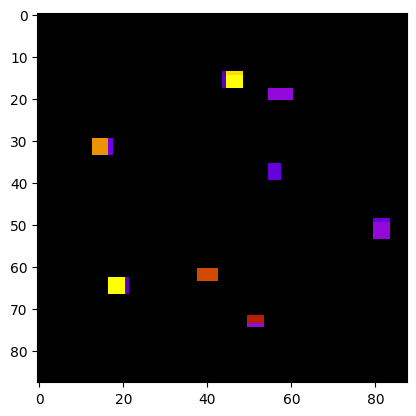

In [6]:
plt.imshow(np.reshape(boxes[20],(88,88)),cmap='gnuplot')
plt.show()

#**Create DataSet**

In [7]:
import tensorflow as tf
import tensorflow.keras as keras

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((Deffect_Images,boxes))

In [9]:
n=1000
dataset = dataset.shuffle(n)
train_dataset = dataset.take(int(n*0.8)).batch(100) # 8 elemnt of shape(100,128,128)
test_dataset = dataset.skip(int(n*0.8)).batch(100) # 2 elemnt of shape(100,128,128)

#**Building The Model**

In [10]:
## layer5 cnn bn he flip
inputs = keras.layers.Input((128,128,1))
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')(x)

x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #126 126 64
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #124 124 64
x = keras.layers.Activation('relu')(x)
x1 = tf.identity(x)
x1 = keras.layers.experimental.preprocessing.CenterCrop(92,92)(x1)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #62 62,64

x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #60 60 128
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #58 58 128
x = keras.layers.Activation('relu')(x)
x2 = tf.identity(x)
x2 = keras.layers.experimental.preprocessing.CenterCrop(50,50)(x2)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #29 29 128

x = keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #27 27 256
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #25 25 256
x = keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 50 50 128

x = keras.layers.Concatenate()([x,x2]) #50 50 256
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #48 48 128
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #46 46 128
x = keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 92 92 64

x = keras.layers.Concatenate()([x,x1]) #92,92 128
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #90 90 64
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 64
x = keras.layers.Activation('relu')(x)

outputs = keras.layers.Conv2D(filters=7,kernel_size=1,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 7

In [11]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 1)          0         ['input_1[0][0]']             
                                                                                                  
 random_flip (RandomFlip)    (None, 128, 128, 1)          0         ['rescaling[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         640       ['random_flip[0][0]']         
                                                                                              

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
hist = model.fit(train_dataset, epochs=500,validation_data=test_dataset)

Epoch 1/500
8/8 [==============================] - 36s 662ms/step - loss: 0.5210 - accuracy: 0.8610 - val_loss: 0.2169 - val_accuracy: 0.9738
Epoch 2/500
8/8 [==============================] - 5s 578ms/step - loss: 0.1903 - accuracy: 0.9734 - val_loss: 0.1744 - val_accuracy: 0.9728
Epoch 3/500
8/8 [==============================] - 5s 574ms/step - loss: 0.1689 - accuracy: 0.9734 - val_loss: 0.1652 - val_accuracy: 0.9734
Epoch 4/500
8/8 [==============================] - 5s 575ms/step - loss: 0.1654 - accuracy: 0.9734 - val_loss: 0.1640 - val_accuracy: 0.9734
Epoch 5/500
8/8 [==============================] - 5s 571ms/step - loss: 0.1664 - accuracy: 0.9730 - val_loss: 0.1575 - val_accuracy: 0.9744
Epoch 6/500
8/8 [==============================] - 5s 569ms/step - loss: 0.1655 - accuracy: 0.9731 - val_loss: 0.1638 - val_accuracy: 0.9731
Epoch 7/500
8/8 [==============================] - 4s 569ms/step - loss: 0.1641 - accuracy: 0.9732 - val_loss: 0.1628 - val_accuracy: 0.9733
Epoch 8/500


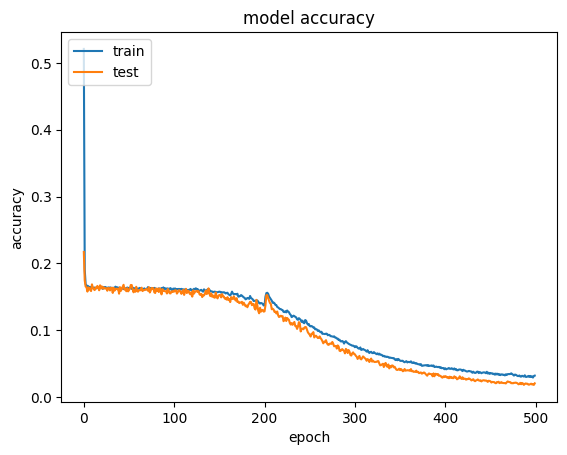

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('model.keras')

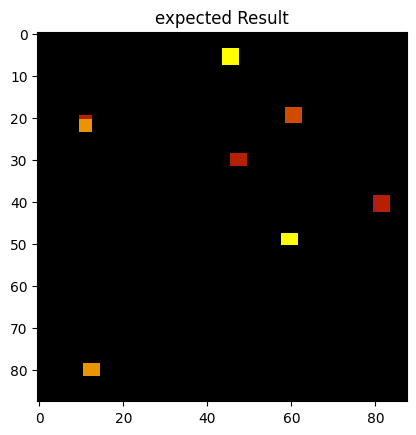

In [25]:
plt.imshow(boxes[1],cmap='gnuplot')
plt.title('expected Result')
plt.show()

1/1 [==============================] - 0s 21ms/step


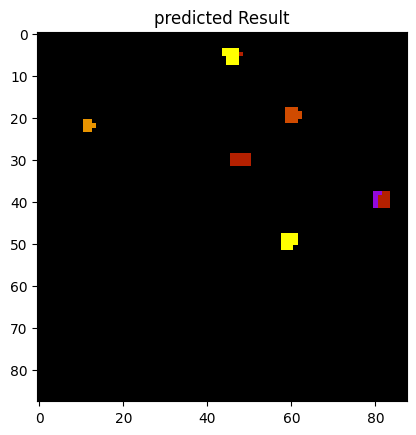

In [26]:
out = model.predict(tf.reshape(Deffect_Images[1],(-1,128,128,1)))
out2 = np.argmax(out,axis=3)
plt.imshow(out2[0],cmap='gnuplot')
plt.title('predicted Result')
plt.show()